# Long Term EMA Crossover System

Philosophy:
The system intends to catch the longer term (i.e. several months or more) large percentage moves in a stock as it gets revalued by the market.
Trends are signalled using an EMA crossover, combined with a selection of fundamental filters to improve performance.
    

In [1]:
# Set up global imports including related packages
import matplotlib.pyplot as plt
import pandas as pd
# Ignore warnings from pandas about assigning to copy of dataframe
pd.set_option('mode.chained_assignment', None)
import sys
import os
sys.path.append(os.path.join("C:\\Users", os.getlogin(), "Source\\Repos\\FinancialDataHandling\\financial_data_handling"))
os.chdir(os.path.join("C:\\Users", os.getlogin(), "Source\\Repos\\EnsembleSystemDevelopment\\ensemble_trading_system"))

# Data storage
from store.file_system import Storage
# System imports
from data_types.market import Market
from system.core import Strategy, Portfolio
from system.core import VolatilityMultiplier, SizingStrategy
from measures.moving_averages import EMA
from measures.volatility import StdDevEMA
from measures.valuations import ValueRatio
from signals.level_signals import Crossover
from rules.signal_rules import PositionFromDiscreteSignal
from trade_modifiers.exit_conditions import StopLoss, TrailingStop, ReturnTriggeredTrailingStop
from trade_modifiers.filters import HighPassFilter
# Import analysis tools
from system.analysis import summary_report, cross_validate_portfolio
# Set up default plot parameters
%matplotlib inline
plt.rcParams["figure.figsize"] = (22, 5)

## Strategy Assessment
The base assessment uses data from the NYSE up to the end of 2015. This data is considered the in-sample period. Once system settings are finalised the performance is re-assessed on the remainder of the NYSE data as well as on ASX data (out of sample).

The base strategy uses an EMA crossover to indicate entries and exits. Trade calculations are conducted at the Close, and trading is conducted at the Open.

In [2]:
store = Storage("NYSE")
# Base System configuration
strategy = Strategy(trade_timing = "O", ind_timing = "C")
strategy.market = Market(store)
strategy.signal_generator = Crossover(slow = EMA(150), fast = EMA(75))
strategy.position_rules = PositionFromDiscreteSignal(Up = 1)

# Run the strategy
strategy.run()
print("Generated {} trades.".format(strategy.trades.count))

Generated 4075 trades.


### Signals
This section contains assessment of the ability of the strategy signals to generate the desired trade profile (e.g. in terms of statistics such as duration, winning percentage, win/loss ratio), as well as the ability of the signals to add performance vs the market.
#### Parameter fuzzing
The base parameters of the strategy are varied to determine the sensitivity of performance and to gauge the suitable parameter settings to attain the desired trade characteristics.

In [3]:
from system.analysis import ParameterFuzzer

fuzzer = ParameterFuzzer(strategy, base_parameters = (150, 75), processes = 1)
fuzzer.fuzzed_pars = [(200, 160), (200, 100), (200, 40), (150, 120), (150, 75), (150, 30), (100, 80), (100, 50), (100, 20)]
fuzzer.summarise()


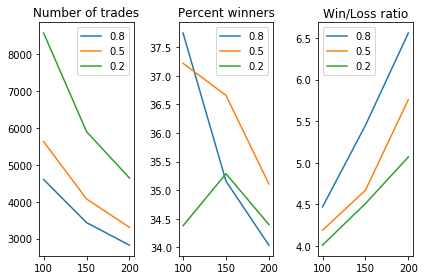

In [4]:
# Assess effect of parameters on winning percentage and win/loss ratio
fig, axarr = plt.subplots(1, 3)
fuzzer.plot_metric('Number of trades', ax = axarr[0])
fuzzer.plot_metric('Percent winners', ax = axarr[1])
fuzzer.plot_metric('Win/Loss ratio', ax = axarr[2])
plt.tight_layout()

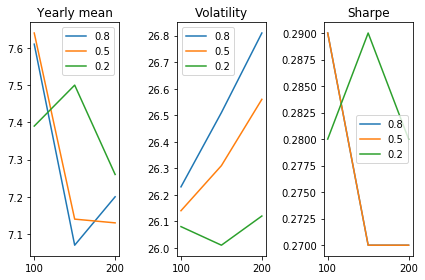

In [5]:
# Assess effect of parameters on return profile
fig, axarr = plt.subplots(1, 3)
fuzzer.plot_metric('Yearly mean', ax = axarr[0])
fuzzer.plot_metric('Volatility', ax = axarr[1])
fuzzer.plot_metric('Sharpe', ax = axarr[2])
plt.tight_layout()

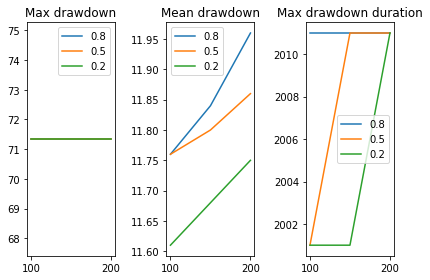

In [6]:
# Assess effect of parameters on drawdown profile
fig, axarr = plt.subplots(1, 3)
fuzzer.plot_metric('Max drawdown', ax = axarr[0])
fuzzer.plot_metric('Mean drawdown', ax = axarr[1])
fuzzer.plot_metric('Max drawdown duration', ax = axarr[2])
plt.tight_layout()

#### Sensitivity analysis
Sensitivity analysis checks the variation in performance of the base strategy with changes in the market constituents. A number of random sub-samples (of tickers) are taken to determine if the overall performance is driven by only a few good results.

In [7]:
from system.analysis import Sampler
sampler = Sampler(N = 200, subset_fraction = 0.5)
sampler.check_robustness(strategy.returns)

Running 200 samples: ........................................................................................................................................................................................................
done.


(<Figure size 432x288 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001CB8ED60A58>,
       dtype=object))

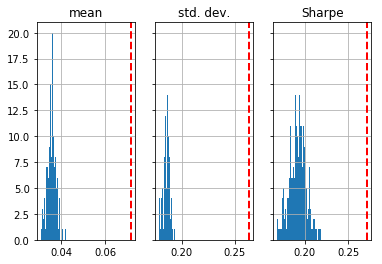

In [8]:
sampler.sample_hist(bins = 40)

### Filters
#### Investigate performance vs filter values
Assess the ability of the selected filters to improve performance without limiting the number of trades too much.


In [9]:
# Load the filter data
adjusted = ValueRatio('EPV', 'Adjusted')(strategy)
cyclic = ValueRatio('EPV', 'Cyclic')(strategy)
from system.analysis import FilterPerformance
fp = FilterPerformance(strategy.trades)
fp.add(adjusted, cyclic)
adjusted_results = fp.summarise(adjusted.name, bins = [-1000, -2, -1.5, -1, -0.5, 0, 0.5, 1.0, 1.5, 2, 1000])
cyclic_results = fp.summarise(cyclic.name, bins = [-1000, -2, -1.5, -1, -0.5, 0, 0.5, 1.0, 1.5, 2, 1000])

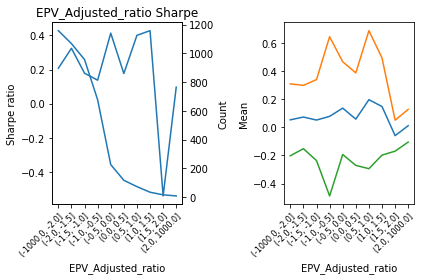

In [10]:
# Review the performance vs Adjusted EPV
fig, axarr = plt.subplots(1, 2)
fp.result = adjusted_results
fp.plot_Sharpe(ax = axarr[0])
fp.plot_count(ax = axarr[0])
fp.plot_mean(ax = axarr[1])
fp.set_x_labels(axarr[0])
fp.set_x_labels(axarr[1])
plt.tight_layout()

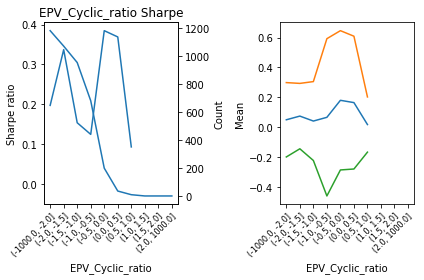

In [11]:
# Review the performance vs Cyclic EPV
fig, axarr = plt.subplots(1, 2)
fp.result = cyclic_results
fp.plot_Sharpe(ax = axarr[0])
fp.plot_count(ax = axarr[0])
fp.plot_mean(ax = axarr[1])
fp.set_x_labels(axarr[0])
fp.set_x_labels(axarr[1])
plt.tight_layout()

#### Filter robustness
We try to assess whether the filter performance was achieved only through chance. Random samples of the same size as the filtered trades are taken from the base set of trades. The distribution of the random samples is then plotted against the filtered results.

In [12]:
# Configure and apply filters
base_trades = strategy.trades
base_returns = strategy.returns
strategy.apply(HighPassFilter(adjusted, -0.5))
filtered_trades = strategy.trades
filtered_returns = strategy.returns
print('Filtered down to {} trades'.format(filtered_trades.count))

Filtered down to 226 trades


Running 200 samples: ........................................................................................................................................................................................................
done.


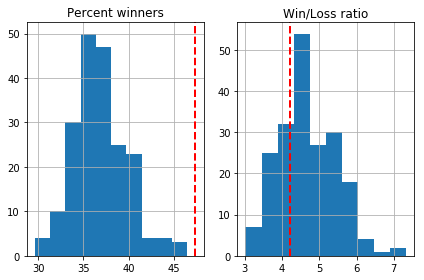

In [13]:
# Run the sampler on the filtered trades
sampler.check_selection_skill(filtered_trades, base_trades)
fig, axarr = plt.subplots(1, 2)
sampler.skill_hist('Percent winners', ax = axarr[0])
sampler.skill_hist('Win/Loss ratio', ax = axarr[1])
plt.tight_layout()



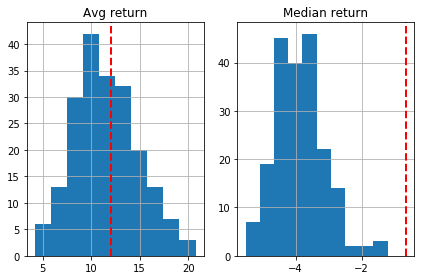

In [14]:
fig, axarr = plt.subplots(1, 2)
sampler.skill_hist('Avg return', ax = axarr[0])
sampler.skill_hist('Median return', ax = axarr[1])
plt.tight_layout()

### Stops
#### Stop loss

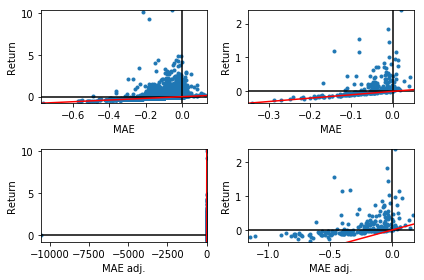

In [15]:
# Plot the maximum adverse excursion and maximum favourable excursion for the filtered trades.
fig, axarr = plt.subplots(2, 2)
base_trades.plot_MAE(ax = axarr[0, 0])
filtered_trades.plot_MAE(ax = axarr[0, 1])
volatilities = StdDevEMA(40)(strategy.trade_prices)
base_trades.plot_MAE_vol_adjusted(volatilities, ax = axarr[1, 0])
filtered_trades.plot_MAE_vol_adjusted(volatilities, ax = axarr[1, 1])
plt.tight_layout()

Definitely some scope for stop losses, potentially at around 15%

In [16]:
# Analysis of various stop loss settings
from system.analysis import test_stop_loss, test_trailing_stop
stop_loss_summary = test_stop_loss(strategy, [0.3, 0.2, 0.15, 0.1, 0.05, 0.02])
print(stop_loss_summary)

                             base  StopLoss0.3  StopLoss0.2  StopLoss0.15  \
Number of trades           226.00       226.00       226.00        226.00   
Percent winners             47.35        47.35        47.35         46.90   
Number of winners          107.00       107.00       107.00        106.00   
Number of losers           119.00       119.00       119.00        120.00   
Number even                  0.00         0.00         0.00          0.00   
Avg return                  12.06        12.08        12.32         12.48   
Avg return inc slippage     10.96        10.98        11.22         11.38   
Median return               -0.65        -0.65        -0.65         -0.86   
Average winner              34.61        34.61        34.61         34.71   
Average loser               -8.21        -8.17        -7.73         -7.15   
Win/Loss ratio               4.22         4.24         4.48          4.85   
Largest winner             239.25       239.25       239.25        239.25   

Suprisingly still good results even with a tight 2% stop, however best seems to be around 10%

#### Trailing stops

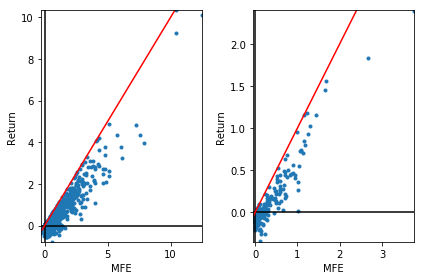

In [17]:
# Plot maximum favourable excursion to check typical end trade drawdowns.
fig, axarr = plt.subplots(1, 2)
base_trades.plot_MFE(ax = axarr[0])
filtered_trades.plot_MFE(ax = axarr[1])
plt.tight_layout()

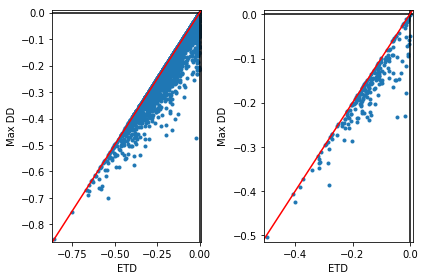

In [18]:
fig, axarr = plt.subplots(1, 2)
base_trades.plot_ETD_vs_DD(ax = axarr[0])
filtered_trades.plot_ETD_vs_DD(ax = axarr[1])
plt.tight_layout()

Larger trades will typically give up more than 10% (base system), and 20-30% (filtered system).

In [19]:
# Trailing stop analysis
trailing_stop_summary = test_trailing_stop(strategy, [0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.02])
print(trailing_stop_summary)

                             base  StopLoss0.3  StopLoss0.2  StopLoss0.15  \
Number of trades           226.00       226.00       226.00        226.00   
Percent winners             47.35        47.35        47.35         46.90   
Number of winners          107.00       107.00       107.00        106.00   
Number of losers           119.00       119.00       119.00        120.00   
Number even                  0.00         0.00         0.00          0.00   
Avg return                  12.06        12.08        12.32         12.48   
Avg return inc slippage     10.96        10.98        11.22         11.38   
Median return               -0.65        -0.65        -0.65         -0.86   
Average winner              34.61        34.61        34.61         34.71   
Average loser               -8.21        -8.17        -7.73         -7.15   
Win/Loss ratio               4.22         4.24         4.48          4.85   
Largest winner             239.25       239.25       239.25        239.25   

Interestingly the Sharpe ratio (exluding slippage) and optimal F ratio continue to increase with tighter trailing stops.
However the typical trade duration and average return drops too far.
A trailing stop of 10-15% seems to be appropriate.

In [20]:
# Add stops and compare results
strategy.apply(StopLoss(0.1))
strategy.apply(TrailingStop(0.1))
stopped_trades = strategy.trades
strategy.summary()

Number of trades             226.00
Percent winners               53.10
Number of winners            120.00
Number of losers             106.00
Number even                    0.00
Avg return                     5.93
Avg return inc slippage        4.83
Median return                  0.94
Average winner                15.93
Average loser                 -5.39
Win/Loss ratio                 2.95
Largest winner               115.42
Largest loser                 -9.99
Average duration              90.90
Average duration winners     119.60
Average duration losers       58.40
Yearly mean                    6.91
Volatility                    25.92
Sharpe                         0.27
Skew                           2.21
Geometric growth               3.61
Max drawdown                  71.34
Mean drawdown                 11.72
Max drawdown duration       2011.00
Avg drawdown duration        355.18
dtype: float64

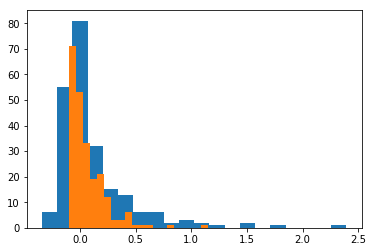

In [21]:
filtered_trades.hist(bins = 20)
strategy.trades.hist(bins = 20)